In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
addplant = pd.read_csv("add-plant.csv")
addplant.head()

,participant_id,condition,reaction_time,major_errors,minor_erros,clicks,confidence,outcome_certainty,perceived_speed,navigation_clarity,error_recovery_ease,group
0,2,A,6952,0,0,6,7,4,7,7,7,0
1,2,B,1862,0,0,3,7,7,7,7,7,0
2,3,A,4198,2,0,5,4,7,6,7,4,0
3,3,B,6498,0,0,3,6,7,6,6,7,0
4,12,A,4004,1,0,3,7,7,7,7,6,0


In [ ]:
addplant["condition"] = addplant["condition"].astype("category")
addplant.dtypes

participant_id            int64
condition              category
reaction_time             int64
major_errors              int64
minor_erros               int64
clicks                    int64
confidence                int64
outcome_certainty         int64
perceived_speed           int64
navigation_clarity        int64
error_recovery_ease       int64
group                     int64
dtype: object

In [ ]:
def order_effect_check(df, dv, group_col="group",
                       id_col="participant_id", cond_col="condition",
                       a="A", b="B", title=None):
    title = title or dv

    wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
    groups = df[[id_col, group_col]].drop_duplicates(id_col)
    wide = wide.merge(groups, on=id_col, how="left")
    wide = wide.dropna(subset=[a, b])

    wide["diff_A_minus_B"] = wide[a] - wide[b]

    g0 = wide.loc[wide[group_col] == 0, "diff_A_minus_B"]
    g1 = wide.loc[wide[group_col] == 1, "diff_A_minus_B"]

    print(f"\n=== Order effect: {title} ===")
    print("n group0 =", len(g0), "n group1 =", len(g1))
    print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

    t, p = stats.ttest_ind(g0, g1, equal_var=False)  # Welch
    print(f"Welch t-test on diffs: t = {t:.3f}, p = {p:.4f}")

    # Plot: diffs by order group
    plt.figure()
    plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])
    plt.title(f"{title}: differences (A-B) by order group")
    plt.ylabel(f"{a}-{b}")
    plt.show()

    return wide

## order effect check

reaction time

In [ ]:

wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="reaction_time",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 1904.5714285714287 mean diff group1 = 591.6
order effect on diff (Welch): t = 0.5756785320996402 p = 0.5826856984144262


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_22020/4237587484.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(



=== Order effect: AddPlant: Reaction Time (ms) ===
n group0 = 7 n group1 = 5
mean diff group0 = 1904.5714285714287 mean diff group1 = 591.6
Welch t-test on diffs: t = 0.576, p = 0.5827


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


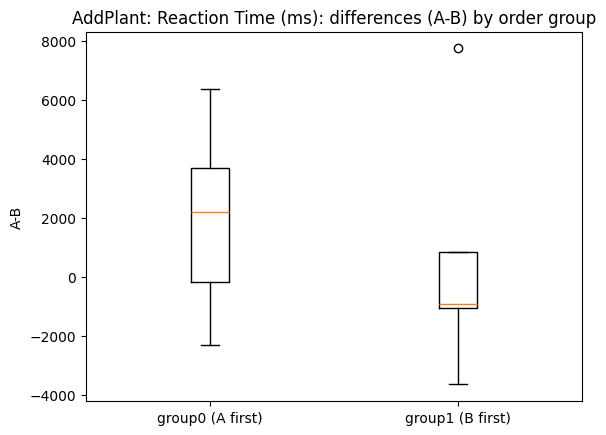

,participant_id,A,B,group,diff_A_minus_B
0,1,9576.0,3193.0,0,6383.0
1,2,6952.0,1862.0,0,5090.0
2,3,4198.0,6498.0,0,-2300.0
3,4,2610.0,4433.0,0,-1823.0
4,5,5330.0,3831.0,0,1499.0
5,6,1382.0,2449.0,1,-1067.0
6,7,5404.0,6329.0,1,-925.0
7,8,8955.0,8109.0,1,846.0
8,9,10744.0,2989.0,1,7755.0
9,10,5296.0,8947.0,1,-3651.0


In [ ]:
order_effect_check(addplant, "reaction_time", title="AddPlant: Reaction Time (ms)")

errors

In [ ]:

wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="errors",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.14285714285714285 mean diff group1 = 0.0
order effect on diff (Welch): t = 0.3110855084191276 p = 0.7662600657593479


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/3401044036.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


clicks

In [ ]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="clicks",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.42857142857142855 mean diff group1 = 0.0
order effect on diff (Welch): t = 0.5960395606792697 p = 0.5729317850717073


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/2533078345.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


confidence

In [ ]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="confidence",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = -0.42857142857142855 mean diff group1 = 0.0
order effect on diff (Welch): t = -1.161895003862225 p = 0.2894032248467901


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/252020605.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


outcome_certainty

In [ ]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="outcome_certainty",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = -0.42857142857142855 mean diff group1 = 0.4
order effect on diff (Welch): t = -1.6785173325023746 p = 0.12717198903057056


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/362847905.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


perceived_speed

In [ ]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="perceived_speed",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.42857142857142855 mean diff group1 = 0.4
order effect on diff (Welch): t = 0.07415889498137032 p = 0.9423465365013336


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/2482791086.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


navigation_clarity

In [ ]:
wide = addplant.pivot_table(
    index="participant_id",
    columns="condition",
    values="navigation_clarity",
    aggfunc="mean"
).reset_index()

groups = addplant[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.5714285714285714 mean diff group1 = 0.0
order effect on diff (Welch): t = 1.3333333333333333 p = 0.23080940884182116


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_4362/307408635.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = addplant.pivot_table(


error_recovery_ease